In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv').sample(frac=1)[:30000] # This shuffles the rows
df = pd.read_csv('fen_analysis.csv')[:30000] # no shuffle
df

,fen_value,score
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-33
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,34
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,-30
3,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,30
4,r1bqkbnr/pppp1ppp/2n5/4p3/2B1P3/5N2/PPPP1PPP/R...,-29
...,...,...
29995,rn1qkb1r/pp2pppp/2p5/1B1p1b2/3P4/4PN1P/PPPB1PP...,23
29996,rn1qkb1r/pp2pppp/2p5/3p1b2/B2P4/4PN1P/PPPB1PP1...,16
29997,rn1qkb1r/1p2pppp/2p5/p2p1b2/B2P4/4PN1P/PPPB1PP...,7
29998,rn1qkb1r/1p2pppp/2p5/p2p1b2/B2P4/2P1PN1P/PP1B1...,-5


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
X

tensor([[ 9, 11, 10,  ...,  0, 39, 39],
        [ 9, 11, 10,  ...,  0, 39, 39],
        [ 9, 11, 10,  ...,  0, 39, 39],
        ...,
        [ 9, 11,  0,  ...,  0, 36, 36],
        [ 9, 11,  0,  ...,  0, 36, 36],
        [ 9, 11,  0,  ...,  0, 36, 36]], dtype=torch.int32)

In [7]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings, dtype=torch.float32)

In [8]:
X.shape, y.shape

(torch.Size([30000, 200]), torch.Size([30000]))

# Helper Functions

In [9]:
val_split = 10000
test_split = 10000

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.float32)
    return x, y
# b = get_batch(X, y, 64)

In [12]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:val_split+test_split].to(device)
y_test = y[val_split:val_split+test_split].to(device)
X = X[test_split:]
y = y[test_split:]

In [13]:
len(X)

20000

# Training

In [14]:
# hyperparameters
lr = 0.1
num_steps = 500
warmup_steps = 50
bs = len(X)
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs > len(X): bs = len(X)

In [15]:
from torch.optim.lr_scheduler import LambdaLR


In [16]:
 # i accidenly used a smaller lr for scheduler and it worked better, maybe try it?

In [17]:
model = MLPEngine(embedding_dim=64).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(
            model.parameters(), 
            lr = lr,
            betas=(0.9, 0.999),
            eps=1e-3,
            weight_decay=1e-5)

# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < warmup_steps:  
        return epoch / warmup_steps
    else:  # Exponential decay after warm-up
        return 0.99 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model = model
model.compile()

In [18]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')

In [19]:
train_history = {}
val_history = {}
start_step = 0

In [20]:
model.train()
# train_history = {}
# val_history = {}
for step_i in range(num_steps):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    # print(f"Epoch {step_i}, Learning Rate: {scheduler.get_last_lr()}")
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0:
        # validation phase
        y_pred = model(X_val).view(val_split)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_category(y_pred, y_val)
        # print(loss.item())
        val_history[tot_step] = loss.item()

start_step += num_steps

0 :  2005743.125
1 :  2189269.0
2 :  1943726.0
3 :  2038655.75
4 :  2195555.75
5 :  1908883.625
6 :  2001819.375
7 :  2043625.375
8 :  2030050.0
9 :  1957237.125
10 :  2027193.125
11 :  2073738.25
12 :  2086012.5
13 :  1945482.0
14 :  1967322.25
15 :  2006393.25
16 :  1982198.75
17 :  2047629.875
18 :  2046327.75
19 :  1860388.875
20 :  2040004.125
21 :  2065089.75
22 :  1886178.875
23 :  1941347.125
24 :  1854858.375
25 :  1888455.625
26 :  1822138.375
27 :  1717225.25
28 :  1665857.625
29 :  1760178.125
30 :  1634847.125
31 :  1586764.75
32 :  1517833.125
33 :  1437530.125
34 :  1458738.125
35 :  1437650.25
36 :  1280206.75
37 :  1176515.75
38 :  1037593.75
39 :  1122222.5
40 :  1121422.625
41 :  944462.625
42 :  751471.875
43 :  669550.875
44 :  711519.4375
45 :  500711.96875
46 :  458820.90625
47 :  374428.0
48 :  320548.125
49 :  286473.65625
50 :  224297.390625
51 :  234547.46875
52 :  224167.796875
53 :  212791.953125
54 :  218769.9375
55 :  212076.59375
56 :  212993.53125
57 : 

In [21]:
torch.save(model.state_dict(), 'saves/bad_model.pt')

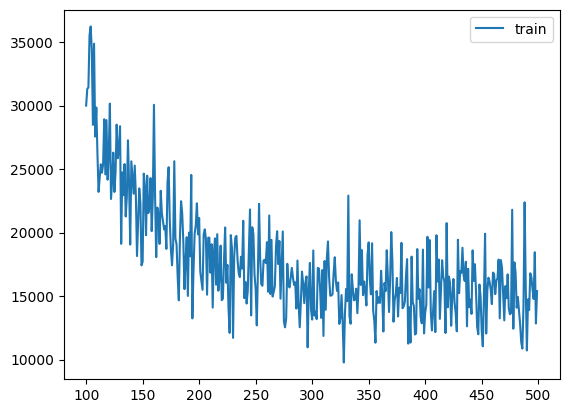

In [22]:
plt.plot(list(train_history.keys())[100:], list(train_history.values())[100:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

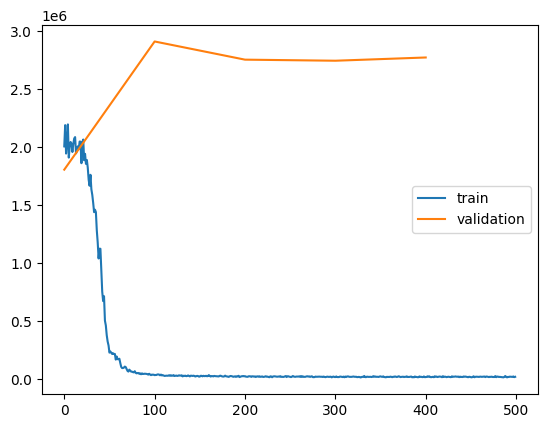

In [23]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [24]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# TO DO

- [x] do inference, and run a partially trained model with the GUI intact
- [ ] **find a way to fix the fact that our model is giving integer loss
- [ ] **Fix the bug in initialisation
- [ ] implement weights and biases or tensorboard 
- [ ] improve the model
  - [ ] get a better/ bigger dataset
  - [ ] hyperparameter and architecture
    - [ ] add CNN
    - [x] better encoding
    - [ ] residual connections
    - [ ] try adamW after tuning b1 and b2
    - [ ] increase embedding dim
    - [ ] increase neurons in the layers
    - [ ] increase layers in the network
    - [ ] change loss function (maybe)
    - [ ] try diff learning rate scheduler(trapeziodal)
    - [ ] Add regularisation
      - [ ] l1,l2
      - [ ] dropout
    - [ ] Better initialisation
    - [ ] diff optimisation algorithm

- make the init proper by specifying the activation in the init as claude said
-  no cnn right now, maybe in future
- 